
✔️ Kernel variables and outputs cleared.
✔️ CUDA cache cleared (if GPU available).

[INFO] GPU Diagnostics:
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3080
CUDA Version: 12.8

[INFO] Running on: cuda

[INFO] Video Duration: 1507s | FPS: 30.0

[STEP 1] Segmenting video into frames, audio, and motion...


Segmenting: 100%|██████████| 3014/3014 [32:39<00:00,  1.54segment/s]


[DONE] Extracted 3014 segments.

[STEP 2] Loading CLIP & CLAP models...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[DONE] Models loaded.

[STEP 3] Extracting embeddings...


Embedding Extraction: 100%|██████████| 3014/3014 [05:16<00:00,  9.52segment/s]


[DONE] Combined Embedding Shape: (3014, 1281)

[STEP 4] Building FAISS index...
[DONE] FAISS index built with 3014 entries.



Querying:   0%|          | 0/5 [00:00<?, ?query/s]


[QUERY] 'Bird is flying in sky'
[Adaptive Weights] Visual=0.55, Audio=0.25, Motion=0.2
 - Match 1: 13m 1s | Score: 0.952


 - Match 2: 12m 44s | Score: 0.842


 - Match 3: 1m 32s | Score: 0.697


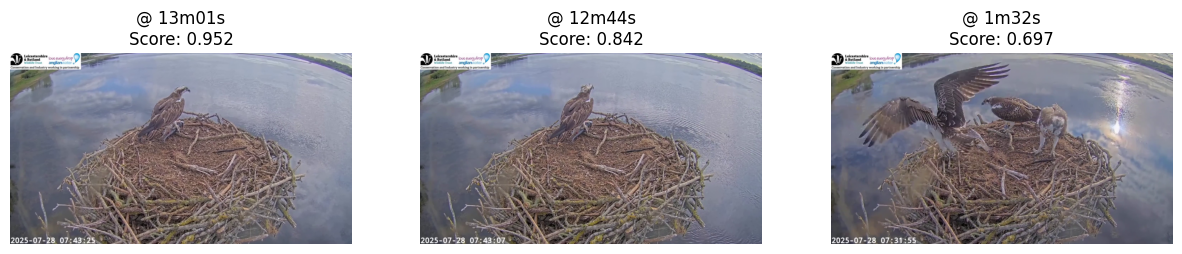

Querying:  20%|██        | 1/5 [00:03<00:12,  3.13s/query]


[QUERY] 'Bird landing in nest'
[Adaptive Weights] Visual=0.55, Audio=0.25, Motion=0.2
 - Match 1: 13m 1s | Score: 0.548


 - Match 2: 12m 44s | Score: 0.511


 - Match 3: 13m 1s | Score: 0.424


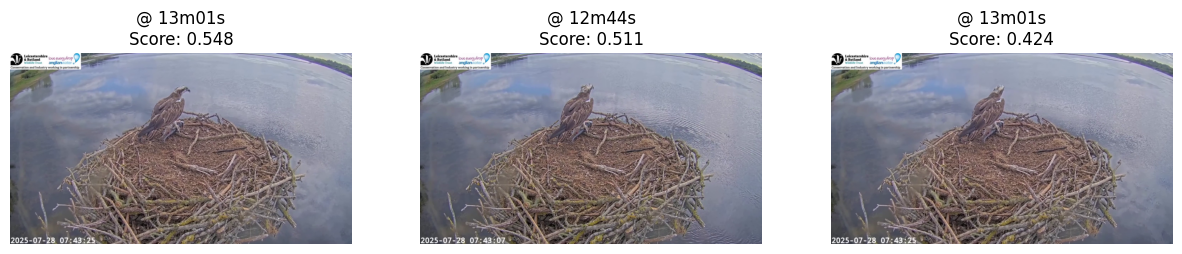

Querying:  40%|████      | 2/5 [00:06<00:09,  3.07s/query]


[QUERY] 'Bird flapping wings'
[Adaptive Weights] Visual=0.55, Audio=0.25, Motion=0.2
 - Match 1: 13m 1s | Score: 0.983


 - Match 2: 12m 44s | Score: 0.850


 - Match 3: 13m 0s | Score: 0.669


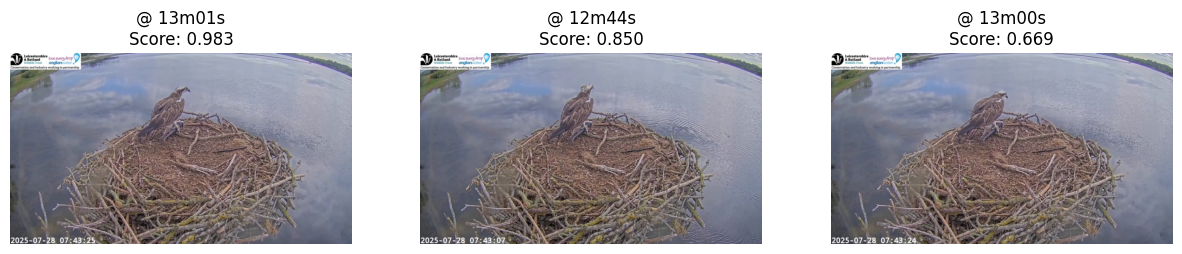

Querying:  60%|██████    | 3/5 [00:09<00:06,  3.13s/query]


[QUERY] 'Bird is feeding babies'
[Adaptive Weights] Visual=0.55, Audio=0.25, Motion=0.2
 - Match 1: 6m 8s | Score: 0.215


 - Match 2: 6m 47s | Score: 0.211


 - Match 3: 1m 38s | Score: 0.210


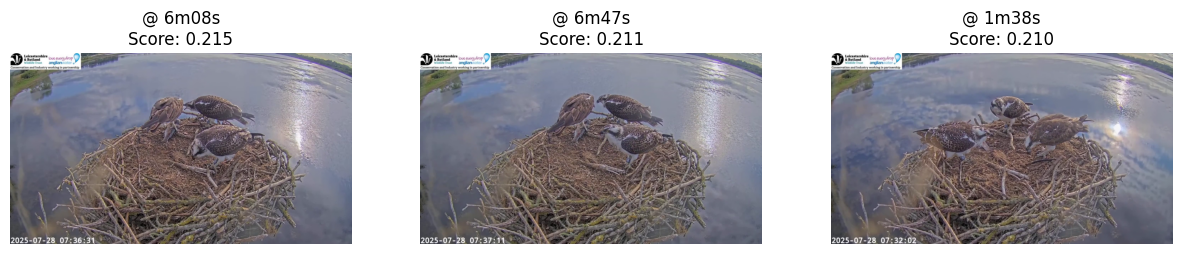

Querying:  80%|████████  | 4/5 [00:12<00:03,  3.17s/query]


[QUERY] 'Bird is calling'
[Adaptive Weights] Visual=0.55, Audio=0.25, Motion=0.2
 - Match 1: 0m 30s | Score: 0.241


 - Match 2: 2m 50s | Score: 0.231


 - Match 3: 11m 28s | Score: 0.228


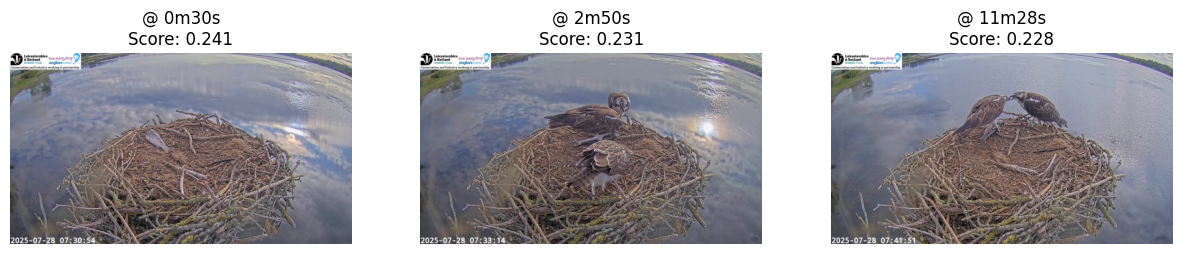

Querying: 100%|██████████| 5/5 [00:15<00:00,  3.19s/query]


In [1]:
# ====================================================
# 🔁 RESET KERNEL & CLEAR STATE
# ====================================================
from IPython import get_ipython
def reset_kernel_state():
    shell = get_ipython()
    if shell is not None:
        shell.run_line_magic('reset', '-f')
        shell.run_line_magic('clear', '')
        print("✔️ Kernel variables and outputs cleared.")

reset_kernel_state()

# Re-import essentials
import torch
torch.cuda.empty_cache()
print("✔️ CUDA cache cleared (if GPU available).")

# ====================================================
# 🔧 GPU DIAGNOSTICS
# ====================================================
print("\n[INFO] GPU Diagnostics:")
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ====================================================
# ✅ IMPORTS & CONFIGURATION
# ====================================================
import os
import cv2
import librosa
import numpy as np
import faiss
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import Audio
from transformers import CLIPModel, CLIPProcessor, ClapModel, AutoProcessor, AutoTokenizer

# -------------------
# PATHS & SETTINGS
# -------------------
VIDEO_PATH = r"C:\Users\Sravan Reddy\Downloads\Video\osprey_nest.mp4"
EXPORT_DIR = r"C:\Users\Sravan Reddy\Downloads\Video\retrieval_results"
os.makedirs(EXPORT_DIR, exist_ok=True)

SEGMENT_DURATION = 0.5  # 0.5s for fine-grained segments
AUDIO_SR = 48000
TOP_K = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n[INFO] Running on: {device}")

# ====================================================
# 🎬 VIDEO SEGMENTATION (FRAMES + AUDIO + MOTION)
# ====================================================
video_clip = VideoFileClip(VIDEO_PATH)
fps = video_clip.fps
video_duration = int(video_clip.duration)
print(f"\n[INFO] Video Duration: {video_duration}s | FPS: {fps}")

segment_timestamps, segment_frames, segment_audio_waveforms, motion_features = [], [], [], []
print("\n[STEP 1] Segmenting video into frames, audio, and motion...")

cap = cv2.VideoCapture(VIDEO_PATH)
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

for t in tqdm(np.arange(0, video_duration, SEGMENT_DURATION), desc="Segmenting", unit="segment"):
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret, frame = cap.read()
    if not ret: break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    segment_frames.append(frame_rgb)
    segment_timestamps.append(t)

    # Optical Flow (motion)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    motion_features.append(np.mean(mag))
    prev_gray = gray

    # Audio
    audio_segment = video_clip.subclip(t, min(t + SEGMENT_DURATION, video_duration)).audio
    audio_array = audio_segment.to_soundarray(fps=AUDIO_SR)
    if audio_array.ndim == 2:
        audio_array = audio_array.mean(axis=1)  # mono
    segment_audio_waveforms.append(audio_array)

cap.release()
print(f"[DONE] Extracted {len(segment_frames)} segments.\n")

# ====================================================
# 🤖 LOAD CLIP (Visual) & CLAP (Audio)
# ====================================================
print("[STEP 2] Loading CLIP & CLAP models...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clap_model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
clap_tokenizer = AutoTokenizer.from_pretrained("laion/clap-htsat-unfused")
clap_processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")
print("[DONE] Models loaded.\n")

# ====================================================
# 🔎 EMBEDDING EXTRACTION
# ====================================================
print("[STEP 3] Extracting embeddings...")
combined_embeds = []

for frame, audio, motion_val in tqdm(zip(segment_frames, segment_audio_waveforms, motion_features),
                                     total=len(segment_frames), desc="Embedding Extraction", unit="segment"):
    # Visual
    image = Image.fromarray(frame)
    clip_inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        img_feat = clip_model.get_image_features(**clip_inputs)
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
    img_feat_np = img_feat.cpu().numpy().astype('float32')

    # Audio
    if audio is not None and len(audio) > 0:
        audio_inputs = clap_processor(audios=[audio], sampling_rate=AUDIO_SR, return_tensors="pt")
        audio_inputs = {k: v.to(device) for k,v in audio_inputs.items()}
        with torch.no_grad():
            audio_feat = clap_model.get_audio_features(**audio_inputs)
        audio_feat = audio_feat / audio_feat.norm(dim=-1, keepdim=True)
        audio_feat_np = audio_feat.cpu().numpy().astype('float32')
    else:
        audio_feat_np = np.zeros((1, clap_model.projection_dim), dtype='float32')

    # Motion
    motion_vec = np.array([[motion_val]], dtype='float32')

    # Combine
    combined_embeds.append(np.concatenate([img_feat_np, audio_feat_np, motion_vec], axis=1))

combined_matrix = np.vstack(combined_embeds)
print(f"[DONE] Combined Embedding Shape: {combined_matrix.shape}")

# ====================================================
# 📦 FAISS INDEX
# ====================================================
print("\n[STEP 4] Building FAISS index...")
dim = combined_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(combined_matrix)
print(f"[DONE] FAISS index built with {index.ntotal} entries.\n")

# ====================================================
# 🔍 QUERY FUNCTION (Adaptive weights + Export)
# ====================================================
def query_video(query_text, top_k=TOP_K, export_results=True):
    print(f"\n[QUERY] '{query_text}'")

    # Encode text (CLIP & CLAP)
    clip_text_inputs = clip_processor(text=[query_text], return_tensors="pt").to(device)
    with torch.no_grad():
        text_vis_feat = clip_model.get_text_features(**clip_text_inputs)
    text_vis_feat = text_vis_feat / text_vis_feat.norm(dim=-1, keepdim=True)
    text_vis_feat_np = text_vis_feat.cpu().numpy().astype('float32')

    clap_text_inputs = clap_tokenizer([query_text], return_tensors="pt").to(device)
    with torch.no_grad():
        text_aud_feat = clap_model.get_text_features(**clap_text_inputs)
    text_aud_feat = text_aud_feat / text_aud_feat.norm(dim=-1, keepdim=True)
    text_aud_feat_np = text_aud_feat.cpu().numpy().astype('float32')

    # Motion heuristic
    motion_score = 1.0 if "fly" in query_text.lower() or "flap" in query_text.lower() else 0.5 if "landing" in query_text.lower() else 0.0
    motion_vec = np.array([[motion_score]], dtype='float32')

    # Fusion weights (adaptive)
    WEIGHT_VISUAL, WEIGHT_AUDIO, WEIGHT_MOTION = 0.55, 0.25, 0.20
    print(f"[Adaptive Weights] Visual={WEIGHT_VISUAL}, Audio={WEIGHT_AUDIO}, Motion={WEIGHT_MOTION}")

    # Final query vector
    query_vector = np.concatenate([
        WEIGHT_VISUAL * text_vis_feat_np,
        WEIGHT_AUDIO * text_aud_feat_np,
        WEIGHT_MOTION * motion_vec
    ], axis=1)

    D, I = index.search(query_vector, top_k)
    D, I = D[:, :top_k], I[:, :top_k]

    num_results = min(top_k, len(I[0]))
    plt.figure(figsize=(5*num_results, 5))

    for rank in range(num_results):
        idx = I[0][rank]
        ts = segment_timestamps[idx]
        score = D[0][rank]
        print(f" - Match {rank+1}: {int(ts//60)}m {int(ts%60)}s | Score: {score:.3f}")

        # Plot frame
        plt.subplot(1, num_results, rank+1)
        plt.imshow(segment_frames[idx])
        plt.title(f"@ {int(ts//60)}m{int(ts%60):02d}s\nScore: {score:.3f}")
        plt.axis('off')

        # Audio playback
        display(Audio(segment_audio_waveforms[idx], rate=AUDIO_SR))

        # Export video & audio
        if export_results:
            video_out = os.path.join(EXPORT_DIR, f"{query_text.replace(' ','_')}_match{rank+1}.mp4")
            audio_out = os.path.join(EXPORT_DIR, f"{query_text.replace(' ','_')}_match{rank+1}.wav")
            subclip = video_clip.subclip(ts, min(ts + SEGMENT_DURATION, video_clip.duration))
            subclip.write_videofile(video_out, codec="libx264", audio_codec="aac", verbose=False, logger=None)
            sf.write(audio_out, segment_audio_waveforms[idx], AUDIO_SR)

    plt.show()

# ====================================================
# 🧪 RUN SAMPLE QUERIES
# ====================================================
queries = [
    "Bird is flying in sky",
    "Bird landing in nest",
    "Bird flapping wings",
    "Bird is feeding babies",
    "Bird is calling"
]

from tqdm import tqdm
for q in tqdm(queries, desc="Querying", unit="query"):
    query_video(q, top_k=3)